In [1]:
import Recomandation_models as rm
import Filtering as fl
import pandas as pd
import numpy as np

import math
from time import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import torch.utils.data as data
import torch.distributions as dist

### DATA PREPARATION

In [2]:
df_books = pd.read_csv("books_autorec.csv")
df_ratings = pd.read_csv("ratings_autorec.csv")

df_ratings_with_clusters = df_ratings.merge(
    df_books[['goodreads_book_id', 'cluster']], 
    left_on='book_id', 
    right_on='goodreads_book_id', 
    how='left'
)

# create dictionary with user and ratings
sparse_users = {}
for user_id, group in df_ratings_with_clusters.groupby('user_id'):
    books_ratings_clusters = group[['book_id', 'rating', 'cluster']].values.tolist()
    sparse_users[user_id] = books_ratings_clusters

cluster_sizes = df_books['cluster'].value_counts().sort_index().values

In [3]:
e88 = fl.find_clusters_ratio(sparse_users[88])
print(e88)

[[0, 0.2578125, 33], [1, 0.171875, 22], [8, 0.1328125, 17], [9, 0.1328125, 17], [4, 0.1015625, 13], [5, 0.0703125, 9], [7, 0.046875, 6], [10, 0.03125, 4], [13, 0.0234375, 3], [3, 0.015625, 2], [12, 0.0078125, 1], [14, 0.0078125, 1]]


In [4]:
em88 = fl.embed(sparse_users[88], df_books)
print(len(em88))
print(em88)

300
[[2657, 4], [48855, 3], [1885, 4], [7613, 4], [5107, 3], [4381, 4], [7624, 3], [3, 4], [18135, 3], [5907, 3], [3636, 4], [11127, 3], [77203, 2], [1420, 4], [11486, 5], [168668, 2], [41865, 1], [4981, 3], [6900, 2], [14050, 2], [114345, 3], [7244, 5], [5, 4], [8127, 3], [7604, 5], [136251, 4], [890, 3], [16981, 5], [6, 5], [1, 4], [1869, 4], [343, 3], [38447, 3], [231804, 3], [2, 4], [9791, 3], [8852, 4], [133518, 2], [12232938, 2], [2187, 4], [5148, 5], [39988, 5], [391729, 3], [7733, 4], [19380, 4], [70401, 2], [9717, 3], [1845, 1], [43641, 2], [4900, 1], [51606, 3], [227571, 1], [5043, 5], [76778, 3], [37781, 5], [6514, 4], [14706, 3], [58345, 4], [9777, 4], [187181, 2], [32261, 2], [4953, 4], [8921, 3], [101299, 1], [10890, 2], [11762, 5], [13872, 4], [116236, 3], [3867, 5], [14836, 3], [19089, 4], [14249, 5], [15881, 4], [7728, 3], [227265, 5], [77262, 4], [6759, 4], [14250, 4], [77554, 1], [14201, 4], [7073, 2], [30868, 4], [25078, 4], [5015, 1], [157993, 2], [18545, 3], [1299

In [3]:
ids = np.unique(df_ratings_with_clusters['goodreads_book_id'])
len(ids)

10000

In [ ]:
#used only for the first initialization. never use again. slow
user_embeddings = fl.embed_all_users(sparse_users, df_books, num_processes=8)
data_tensor = torch.stack(user_embeddings)
dataset = data.TensorDataset(data_tensor)
dataloader = data.DataLoader(dataset, batch_size=32, shuffle=True)

  0%|          | 0/53424 [00:00<?, ?it/s]

In [ ]:
#torch.save(user_embeddings,'"C:\Users\pitom\OneDrive\Desktop\materiale uni\data-vis\info retroval\esame\user_embeddings.pt"')

In [4]:
#to use from now on so the data are alredy preprocessed
user_embeddings = torch.load("C:/Users/pitom/OneDrive/Desktop/materiale uni/data-vis/info retroval/esame/user_embeddings.pt")
dataloader = data.DataLoader(user_embeddings,32,shuffle=True)

In [5]:
dataloader.dataset[0].shape

torch.Size([300, 2])

### MODEL CREATION AND TRAINING

In [9]:
def loss(value_sets, x, recon):
    batch_size, seq_len, num_cols = recon.shape
    distances_per_col = []

    for i in range(num_cols):
        col = recon[:, :, i].float()  
        values = value_sets[i].to(recon.device).float()  
        col = col.unsqueeze(-1)                   
        values = values.view(1, 1, -1)           
        distances = torch.abs(col - values)     
        min_distances, _ = distances.min(dim=2) 
        distances_per_col.append(min_distances)

    all_distances = torch.stack(distances_per_col, dim=2)
    total_distance = all_distances.sum()

    x = x.float()
    recon = recon.float()
    mse = F.mse_loss(recon, x)

    return total_distance * 0.0001 + 10000*mse

In [10]:
model = rm.FAE(300, ids)
N_Epochs = 20
criterion = loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=False)

C:\Users\pitom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
losses,parameters,recon,z = rm.train_FAE(model, N_Epochs, dataloader, criterion, optimizer)

Epoch: 1 | Loss: 190190465198516128.0000 | Time: 1080.13
Epoch: 2 | Loss: 178443497376036288.0000 | Time: 1100.96
Epoch: 3 | Loss: 176910575127420064.0000 | Time: 1072.07
Epoch: 4 | Loss: 173901411094855776.0000 | Time: 1053.98
Epoch: 5 | Loss: 171548206125428448.0000 | Time: 1097.19
Epoch: 6 | Loss: 170132101475088512.0000 | Time: 1097.09
Epoch: 7 | Loss: 168755879885912448.0000 | Time: 1097.72
Epoch: 8 | Loss: 167650310439656096.0000 | Time: 1095.28
Epoch: 9 | Loss: 166370329051997600.0000 | Time: 1105.84
Epoch: 10 | Loss: 165698516505424704.0000 | Time: 1152.51
Epoch: 11 | Loss: 165314421527704736.0000 | Time: 1355.48
Epoch: 12 | Loss: 164521764978397728.0000 | Time: 1343.34
Epoch: 13 | Loss: 163797954217495264.0000 | Time: 1290.97
Epoch: 14 | Loss: 162840563088424448.0000 | Time: 1021.15
Epoch: 15 | Loss: 162431121045968384.0000 | Time: 1090.41
Epoch: 16 | Loss: 162082322830032672.0000 | Time: 1333.58
Epoch: 17 | Loss: 161832644770036256.0000 | Time: 1324.88
Epoch: 18 | Loss: 16159

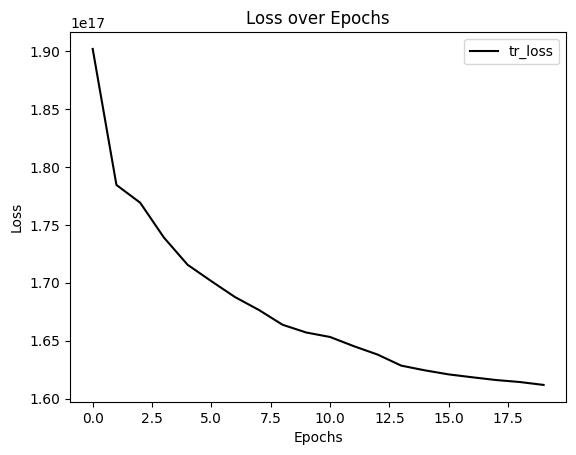

In [12]:
rm.loss_graph(losses,N_Epochs)

In [13]:
import recommendation_system as rs

In [14]:
reccomender = rs.create_recommendation_system(ids = ids)

✅ Modello FAE caricato su cpu
✅ Vettore utente dimensione: 300
✅ Book IDs nel modello: 10000


In [21]:
book_ids_user = [tripla[0] for tripla in sparse_users[88]]
ratings = [tripla[1] for tripla in sparse_users[88]]
titles = df_books.loc[df_books['goodreads_book_id'].isin(book_ids_user),'original_title']
for title, rating in zip(titles, ratings):
    print(title,'      ' ,rating)

Harry Potter and the Philosopher's Stone        4
Twilight        3
To Kill a Mockingbird        4
The Hobbit or There and Back Again        4
The Catcher in the Rye        3
Pride and Prejudice        4
The Kite Runner         3
Animal Farm: A Fairy Story        4
Het Achterhuis: Dagboekbrieven 14 juni 1942 - 1 augustus 1944        3
Harry Potter and the Prisoner of Azkaban        3
Harry Potter and the Order of the Phoenix        4
The Lovely Bones        3
Harry Potter and the Chamber of Secrets        2
Harry Potter and the Goblet of Fire        4
Harry Potter and the Deathly Hallows        5
Harry Potter and the Half-Blood Prince        2
Lord of the Flies         1
An Excellent conceited Tragedie of Romeo and Juliet        3
Of Mice and Men         2
The Giver        2
The Time Traveler's Wife        3
Water for Elephants        5
Fahrenheit 451        4
Slaughterhouse-Five, or The Children's Crusade: A Duty-Dance with Death         3
Bridget Jones's Diary (Bridget Jones, #1)    

In [30]:
original = reccomender._sparse_to_tensor(sparse_users[120])
reconstruction, latent = model(original, force_values=True)
reconstruction

c:\Users\pitom\OneDrive\Desktop\materiale uni\data-vis\info retroval\esame\AutoRec\Recomandation_models.py:49: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1831.)
  std = tensor.std(dim=0, keepdim=True) + 1e-8


tensor([[[1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1.

In [25]:
recomandations = reccomender.recommend_for_user_id(120,sparse_users)
reccomender.print_recommendations(recomandations)

🔍 Processando utente 120 con 77 rating
⚠️  Nessuna nuova raccomandazione trovata
📚 Nessuna raccomandazione trovata
